Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
#train, val split
train, val = train_test_split(train, train_size=.8, stratify=train['status_group'], random_state=22)

In [5]:
def wrangle(x):
    '''
    This function will clean up the dfs.
    '''
    #make a copy to avoid error warning
    x = x.copy()
    
    #convert near zeros to zeros
    x['latitude'] = x['latitude'].replace(-2e-08, 0)
    
    #convert missing values to NaNs and create '_missing column' 
    #to make sure that missing data is not a signal
    cols_w_0 = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
    
    for c in cols_w_0:
        x[c] = x[c].replace(0, np.NaN)
        x[c+'_missing'] = x[c].isnull()
        
    #drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    x[c] = x[c].drop(columns=duplicates)
    
    #drop 'recorded_by' & 'id'
    #'id' because it identifies individual wells (noise)
    #'recorded_by' it is always the same
    noise = ['recorded_by', 'id']
    x = x.drop(columns=noise)
    
    #convert 'date_recorded' to datetime format
    x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)
    
    #extract exponents from 'date_recorded'
    x['year'] = x['date_recorded'].dt.year
    x['month'] = x['date_recorded'].dt.month
    x['day'] = x['date_recorded'].dt.day
    x = x.drop(columns='date_recorded')
    
    #feature engineer column with age of well
    x['age'] = x['year'] - x['construction_year']
    x['year_missing'] = x['year'].isnull()
    
    return x

In [6]:
train =  wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [8]:
#create target vector
target = 'status_group'

#get df without target vectors
train_features = train.drop(columns=[target])

#get a list of numeric features
numeric_list = train_features.select_dtypes(include='number').columns.tolist()

#get a series with the cardinality of nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

#get a list of all cardinal columsn with <= 50 categories
categorical_list = cardinality[cardinality <= 50].index.tolist()

#combine features lists
features = numeric_list + categorical_list

In [10]:
#arrange y vectors and x matrixes
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [12]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [13]:
y_train.value_counts()

functional                 25807
non functional             18259
functional needs repair     3454
Name: status_group, dtype: int64

In [14]:
y_train = y_train.replace({'functional': 1, 'non functional': 2, 'functional needs repair': 3})
y_val = y_val.replace({'functional': 1, 'non functional': 2, 'functional needs repair': 3})

In [16]:
from sklearn.model_selection import RandomizedSearchCV

In [19]:
#build pipeline for model

pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                        SimpleImputer(),
                        RandomForestClassifier(random_state=22))

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': [10, 20, 30, 40, None],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5]
}

search = RandomizedSearchCV(pipeline, 
                           param_distributions=param_distributions,
                           n_iter=30,
                           cv=5,
                           scoring='neg_mean_absolute_error',
                           verbose=10,
                           return_train_score=True,
                           n_jobs=-1)

search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 12.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
  

In [22]:
print(f'Best HyperParameters: {search.best_params_}')
print('Best Validation Score:', -search.best_score_)

Best HyperParameters: {'simpleimputer__strategy': 'median', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 20}
Best Validation Score: 0.24728535353535355


In [23]:
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                        SimpleImputer(strategy='median'),
                        RandomForestClassifier(random_state=22, min_samples_leaf=1, max_depth=20))

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
 

In [25]:
pipeline.score(X_val,y_val)

0.8115319865319865

In [27]:
y_pred = pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.replace({1:'functional', 2:'non functional', 3: 'functional needs repair'})
sample_submission['status_group'] = y_pred
t_submission = sample_submission.copy()
t_submission.to_csv('CJ-Ricciardi-Final-Submission', index=False)

In [28]:
from sklearn.metrics import plot_confusion_matrix

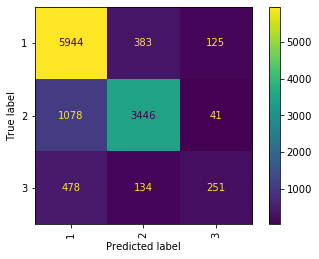

In [30]:
plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation='vertical', values_format='.0f')